<a href="https://colab.research.google.com/github/Whatever929/kaggle_notebook/blob/main/Market_Basket_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks')
%run '/content/drive/MyDrive/Colab Notebooks/setup.ipynb'

In [2]:
# The dataset used in this script can be found in
# https://www.kaggle.com/aslanahmedov/market-basket-analysis

In [3]:
connect_kaggle()

Saving kaggle.json to kaggle (2).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              237KB  2021-12-12 11:59:54          18401  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01          11067  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           5643  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   2GB  2021-10-22 10:4

In [4]:
os.system("kaggle datasets download -d aslanahmedov/market-basket-analysis")

0

In [5]:
unzip("market-basket-analysis.zip")

In [6]:
original = pd.read_csv("Assignment-1_Data.csv", delimiter=';')
df = original.copy()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Overview

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522064 entries, 0 to 522063
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   BillNo      522064 non-null  object 
 1   Itemname    520609 non-null  object 
 2   Quantity    522064 non-null  int64  
 3   Date        522064 non-null  object 
 4   Price       522064 non-null  object 
 5   CustomerID  388023 non-null  float64
 6   Country     522064 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 27.9+ MB


In [8]:
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

In [ ]:
!pip install pycaret

In [10]:
from pandas_profiling import ProfileReport

profile = ProfileReport(df, title="Pandas Profiling Report")

In [11]:
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Data Cleaning

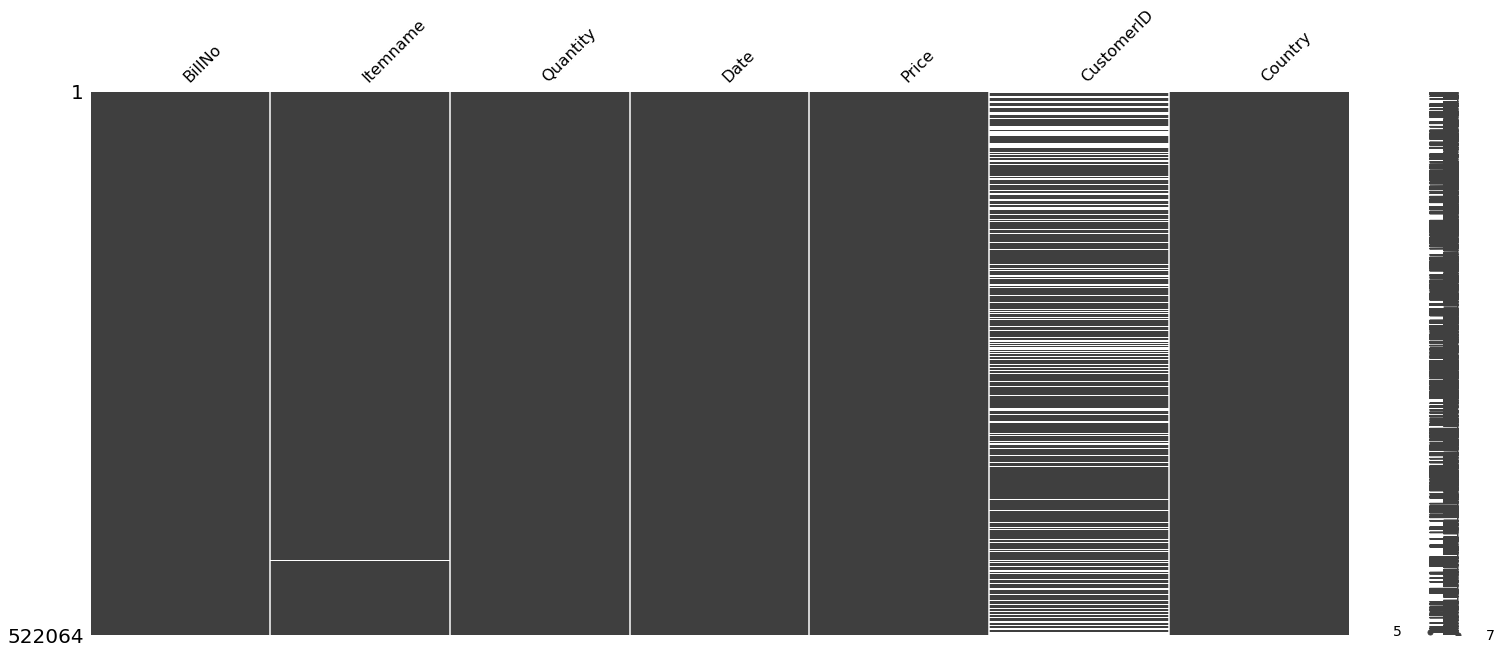

In [12]:
import missingno as msno
%matplotlib inline

msno.matrix(df)

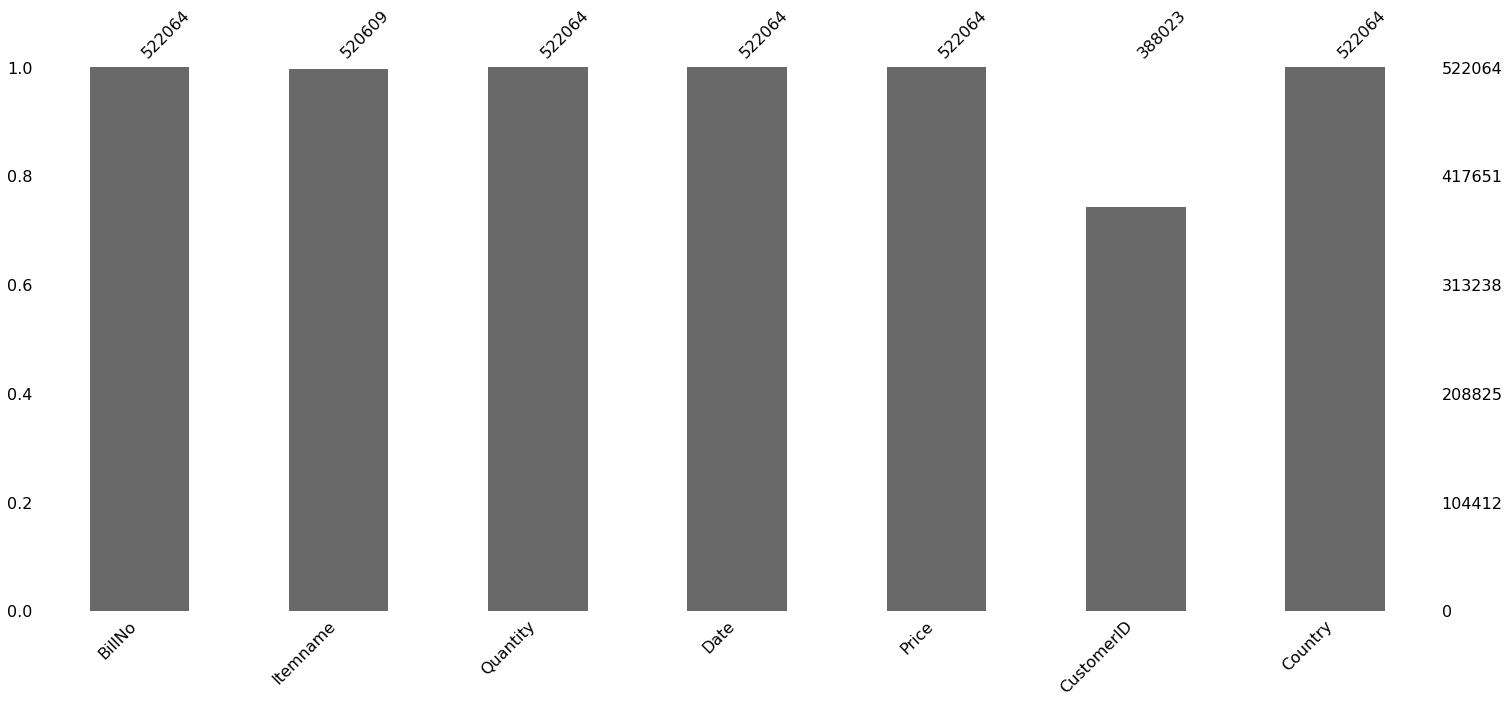

In [13]:
msno.bar(df)

In [14]:
# We will drop all rows with NaN Itemname. 
# It makes no sense to have a model to predict which item is bought together with NaN.
df = df.dropna(subset=['Itemname'])

In [15]:
# Taking a sample of rows from the dataset, it is found that some rows are duplicated.
# We will assume that those are due to purchasing multiple quantity of items.
# Thus we won't drop those rows.

sample = df.sample(10000)
sample[sample.duplicated(keep=False)]

,BillNo,Itemname,Quantity,Date,Price,CustomerID,Country
65892,541843,MINI PAINTED GARDEN DECORATION,12,2011-01-23 12:08:00,"0,85",13659.0,United Kingdom
474902,578233,PINK SCOTTIE DOG W FLOWER PATTERN,2,2011-11-23 12:20:00,"2,55",14049.0,United Kingdom
205818,555524,GREEN REGENCY TEACUP AND SAUCER,1,2011-06-05 11:37:00,"2,95",16923.0,United Kingdom
65884,541843,MINI PAINTED GARDEN DECORATION,12,2011-01-23 12:08:00,"0,85",13659.0,United Kingdom
205829,555524,GREEN REGENCY TEACUP AND SAUCER,1,2011-06-05 11:37:00,"2,95",16923.0,United Kingdom
444296,575950,CHRISTMAS PUDDING TRINKET POT,2,2011-11-13 11:53:00,"0,39",16983.0,United Kingdom
475320,578255,PAPER BUNTING RETROSPOT,1,2011-11-23 12:58:00,"2,95",14675.0,United Kingdom
444298,575950,CHRISTMAS PUDDING TRINKET POT,2,2011-11-13 11:53:00,"0,39",16983.0,United Kingdom
475343,578255,PAPER BUNTING RETROSPOT,1,2011-11-23 12:58:00,"2,95",14675.0,United Kingdom
153569,550331,HANGING WOOD AND FELT HEART,1,2011-04-17 13:43:00,"0,42",15555.0,United Kingdom


In [16]:
# Dropping weird Itemname

missing_keyword = ['missing', '?', 'throw', 'lost', 'find', 'damaged']
unique_itemname = pd.Series(df['Itemname'].unique())
mask = unique_itemname.apply(lambda x: x.islower() or any(i in x for i in missing_keyword))
invalid_itemname = unique_itemname[mask]
invalid_itemname

1723             amazon
1803                  ?
2134              check
2136            damages
2368             faulty
             ...       
4178                wet
4179          wet boxes
4180    ????damages????
4181           mixed up
4182               lost
Length: 133, dtype: object

In [17]:
# We will drop those weird itemnames

df = df[df['Itemname'].apply(lambda x: x not in invalid_itemname.values)]

### EDA

Just doing some data visualizations

Text(0.5, 0.98, 'Distribution of number of bills per customer')

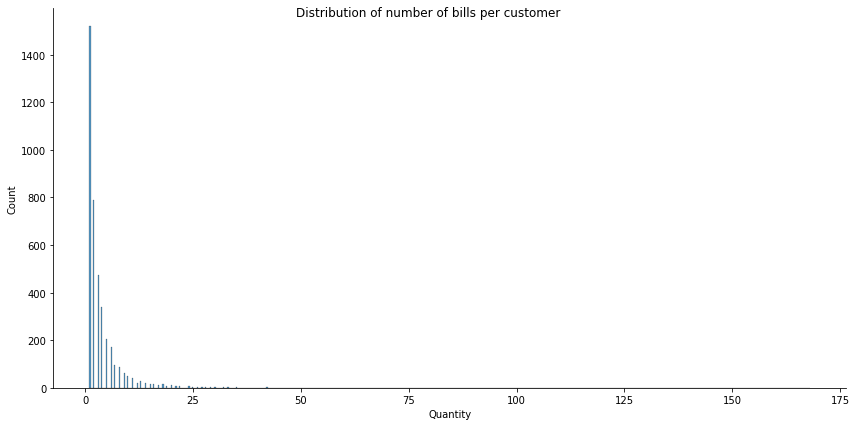

In [18]:
sample = df.sample(100000).dropna()
by_bill = sample.groupby(['BillNo']).agg({'Quantity': 'sum', 'CustomerID': 'first'})
bill_no_by_customer = by_bill.groupby(['CustomerID']).count()
fg = sns.displot(bill_no_by_customer['Quantity'], kind='hist', height=6, aspect=2)
fg.fig.suptitle("Distribution of number of bills per customer")

The distribution graph is right-skewed, with a few customers making unusually large amount of purchase.

Text(0.5, 1.0, 'Monthly number of bills over the year')

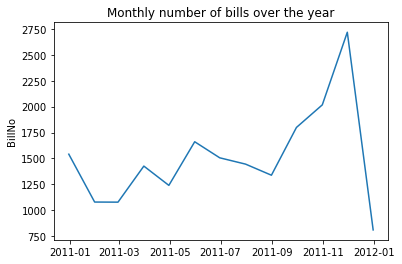

<Figure size 576x720 with 0 Axes>

In [35]:
unique_bill = df.groupby('BillNo').agg({'Date': 'first'}).reset_index()
bill_by_month = unique_bill.groupby(by=pd.Grouper(key='Date', freq='M')).count()
ax = sns.lineplot(data=bill_by_month, x=bill_by_month.index.date, y='BillNo')
plt.figure(figsize=(8, 10))
ax.set_title("Monthly number of bills over the year")

Generally there is an increasing trend for number of transactions/bills. The sharp decrease in monthly number of bills in 2012 is due to the fact that our dataset actually has no entries for year 2012.

### Associative Rule Mining with PyCaret

In [36]:
from pycaret.arules import *

exp = setup(data=df, transaction_id='BillNo', item_id='Itemname')

Description,Value
session_id,452
# Transactions,19658
# Items,4052
Ignore Items,None


In [39]:
# We have to greatly decrease the min_support threshold as the number of rows are huge
model1 = create_model(threshold=0.5, min_support=0.01, low_memory=True)

In [40]:
model1

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(BEADED CRYSTAL HEART PINK ON STICK),(DOTCOM POSTAGE),0.0105,0.0360,0.0102,0.9757,27.0916,0.0098,39.7161
1,"(JAM MAKING SET PRINTED, SUKI SHOULDER BAG)",(DOTCOM POSTAGE),0.0111,0.0360,0.0106,0.9587,26.6193,0.0102,23.3498
2,"(HERB MARKER PARSLEY, HERB MARKER THYME)",(HERB MARKER ROSEMARY),0.0107,0.0119,0.0102,0.9524,80.0081,0.0100,20.7500
3,"(HERB MARKER PARSLEY, HERB MARKER ROSEMARY)",(HERB MARKER THYME),0.0107,0.0119,0.0102,0.9524,80.3515,0.0100,20.7511
4,"(REGENCY TEA PLATE PINK, REGENCY TEA PLATE ROSES)",(REGENCY TEA PLATE GREEN),0.0127,0.0181,0.0120,0.9478,52.4836,0.0118,18.8080
...,...,...,...,...,...,...,...,...,...
886,"(LUNCH BAG CARS BLUE, LUNCH BAG RED RETROSPOT)",(LUNCH BAG WOODLAND),0.0277,0.0511,0.0139,0.5009,9.8078,0.0125,1.9013
887,(JUMBO BAG WOODLAND ANIMALS),(JUMBO BAG PINK POLKADOT),0.0434,0.0616,0.0217,0.5000,8.1164,0.0190,1.8768
888,(PICNIC BASKET WICKER SMALL),(DOTCOM POSTAGE),0.0232,0.0360,0.0116,0.5000,13.8828,0.0108,1.9280
889,(HAND WARMER RED LOVE HEART),(HAND WARMER SCOTTY DOG DESIGN),0.0200,0.0277,0.0100,0.5000,18.0349,0.0095,1.9446
